In [330]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from KDEpy import FFTKDE
from scipy.special import kl_div
from scipy.interpolate import interp1d
from scipy.integrate import quad, trapz
from scipy import integrate

In [331]:
plt.style.use('tableau-colorblind10')

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 16

plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [332]:
# path = '../../data/ail_pdr_meta/sneos_meta_reduced_clean.csv'
path = '../../data/ail_pdr_meta/sneos_meta_reduced_clean_cold.csv'

In [333]:
raw_data = pd.read_csv(path)

In [334]:
raw_data

,EOS int,Mass,M_rem,Outcome Mass Cut
0,0,10.8,1.36478,0
1,0,11.0,1.28748,0
2,0,11.2,1.21519,0
3,0,11.4,1.25311,0
4,0,11.6,1.25983,0
...,...,...,...,...
676,5,26.0,8.29300,1
677,5,36.0,13.88300,1
678,5,38.0,15.16200,1
679,5,40.0,16.51700,1


In [335]:
raw_data.columns = ['EOS', 'ZAMS_mass', 'remnant_mass', 'outcome']

In [336]:
raw_data['outcome'].value_counts()

0    508
1    173
Name: outcome, dtype: int64

In [337]:
raw_data['EOS'].value_counts()

0    179
4    109
3    104
1    101
5    101
2     87
Name: EOS, dtype: int64

In [368]:
state_names = ["DD2", "SFHo", "SFHx", r"BHB$\lambda$$\phi$", "TM1", "NL3"]

In [339]:
states = sorted(raw_data['EOS'].unique())
print(f"Unique EOS: {states}")

Unique EOS: [0, 1, 2, 3, 4, 5]


In [340]:
raw_data['EOS'].value_counts()

0    179
4    109
3    104
1    101
5    101
2     87
Name: EOS, dtype: int64

In [341]:
def compute_noise(data, exp_type):
    data['noise'] = 0
    sigma_bh = 0.120213 * data['remnant_mass'] + 0.355936
    
#     if exp_type == 'nss':
#         sigma_ns = 0.099
#     elif exp_type == 'nsc':
#         sigma_ns = 0.003
#     elif exp_type == 'nse':
#         sigma_ns = 0.28
#     else:
#         sigma_ns = 0.099

    sigma_ns = 0.12
        
    # Compute neutron star noise
    ns_mask = (data['outcome'] == 0)
    ns = data[ns_mask]
    data.loc[ns_mask, 'noise'] = pd.Series(np.random.normal(0, sigma_ns, len(ns_mask)))
    
    # Compute black hole noise
    bh_mask = (data['outcome'] != 0)
    bh = data[bh_mask]
    data.loc[bh_mask, 'noise'] = pd.Series(np.random.normal(0, sigma_bh, len(bh_mask)))
    
    data['remnant_mass_noisy'] = data['remnant_mass'] + data['noise']
#     data['remnant_mass_noisy'] = data['remnant_mass'] + 0
    data.loc[data['remnant_mass_noisy'] < 0, 'remnant_mass_noisy'] = 10e-2
    
    return data

In [342]:
def compute_weights(data):
    m = data['ZAMS_mass'].to_numpy()
    condlist = [m < 0.5, np.logical_and(0.5 <= m, m < 1.0), m >= 1.0]
    funclist = [lambda m: 0.035 * pow(m, -1.3),\
                lambda m: 0.019 * pow(m, -2.2),\
                lambda m: 0.019 * pow(m, -2.7)]
    return np.piecewise(m, condlist, funclist)

In [343]:
mmin = 6.8 # -2.8 + 1.7
alpha = 7.1 # -3.3 + 3.8
mu = 29.8 # -7.3 + 5.8
sigma = 6.4 # -4.2 + 3.2
l = 0.3 # - 0.2 + 0.4
dm = 3 # might be larger?
mmax = 75 # ???

def S(m, m_min, dm):
    out = (m - m_min) / dm
    out[m < m_min] = 0
    out[m > m_min + dm] = 1
    return out

def power_law(m, mmax, alpha):
    return m**(-alpha)

def gaussian(m, mu, sigma):
    return np.exp(-(m-mu)**2/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))

def p_bh(m, l, alpha, mmax, mu, sigma, mmin, dm):
    out = np.zeros_like(m)
    
    inv_A = integrate.quad(lambda m: power_law(m, mmax, alpha), mmin, mmax)[0]
    out += (1-l)*(1./inv_A)*power_law(m, mmax, alpha)
    out[m > mmax] = 0
    out[m <= 10e-2] = 0
    
    out += l*gaussian(m, mu, sigma) * 0 # to remove second bump
  
    out *= S(m, mmin, dm)

    norm_factor = integrate.trapz(out, x=m)
    out /= norm_factor

    return out

In [344]:
band = 0.1

def p_nss(grid):
    p_y = (1 / (np.sqrt(2 * np.pi * pow(0.19, 2))) * 
           np.exp((-pow(grid - 1.49, 2)) / (2 * pow(0.19, 2))))
    return p_y

def p_nsc(grid):
    p_y = (1 / (np.sqrt(2 * np.pi * pow(0.089, 2))) * 
           np.exp((-pow(grid - 1.33, 2)) / (2 * pow(0.089, 2))))
    return p_y

def p_nse(grid):
    p_y = (1 / (np.sqrt(2 * np.pi * pow(0.24, 2))) * 
           np.exp((-pow(grid - 1.29, 2)) / (2 * pow(0.24, 2))))
    return p_y

def p_nsr(grid):
    p_y = (1 / (np.sqrt(2 * np.pi * pow(0.23, 2))) * 
           np.exp((-pow(grid - 1.54, 2)) / (2 * pow(0.23, 2))))
    return p_y

def q(data, grid):
    kde = FFTKDE(bw=band).fit(data['remnant_mass_noisy'].to_numpy(),
                              weights=data['weights'].to_numpy())
    y = kde.evaluate(grid)
    return y

def kl_div(data, grid, exp_type):
    if exp_type == 'bh':
        p_y = p_bh(grid, l, alpha, mmax, mu, sigma, mmin, dm)
    elif exp_type == 'nss':
        p_y = p_nss(grid)
    elif exp_type == 'nsc':
        p_y = p_nsc(grid)
    elif exp_type == 'nse':
        p_y = p_nse(grid)
    else:
        p_y = p_nsr(grid)
    
            
    q_y = q(data, grid)
    norm_p = trapz(p_y, x=grid)
    p_y /= norm_p
    flr = max([10 ** -13, min(p_y), min(q_y)])
    p_y[p_y < flr] = flr
    q_y[q_y < flr] = flr
    return p_y, q_y, p_y * np.log2(p_y / q_y)

def tv_dist(data, grid, exp_type):
    if exp_type == 'bh':
        p_y, q_y = p_bh(grid, l, alpha, mmax, mu, sigma, mmin, dm), q(data, grid)
        norm_p = trapz(p_y, x=grid)
        p_y /= norm_p
        return abs(p_y - q_y)
    elif exp_type == 'nss':
        p_y, q_y = p_nss(grid), q(data, grid)
        norm_p = trapz(p_y, x=grid)
        p_y /= norm_p
        return abs(p_y - q_y)
    elif exp_type == 'nsc':
        p_y, q_y = p_nsc(grid), q(data, grid)
        norm_p = trapz(p_y, x=grid)
        p_y /= norm_p
        return abs(p_y - q_y)
    elif exp_type == 'nse':
        p_y, q_y = p_nse(grid), q(data, grid)
        norm_p = trapz(p_y, x=grid)
        p_y /= norm_p
        return abs(p_y - q_y)
    else:
        p_y, q_y = p_nsr(grid), q(data, grid)
        norm_p = trapz(p_y, x=grid)
        p_y /= norm_p
        return abs(p_y - q_y)

## Run

In [388]:
ns_pdfs = []

In [404]:
exp_type = 'nss'

In [405]:
# Grid of inputs
grid = np.linspace(10e-12, 50, num=2**15)

In [406]:
# Split into states
states_data = []
states_data_clean = []

for state in states:
    states_data.append(raw_data[raw_data['EOS'] == state].reset_index())

In [407]:
# Compute noise
for i, sd in enumerate(states_data):
#     sample = sd.sample(frac=1.0, replace=True, ignore_index=True)
    sample = pd.concat([sd] * 5000, ignore_index=True)
    sample_2 = compute_noise(sample.copy(), exp_type)
    sample_2['weights'] = compute_weights(sample_2.copy())
    states_data_clean.append(sample_2)

In [408]:
### Compute all metrics
ps, qs = [], []

for state, data in enumerate(states_data_clean):
    
    if exp_type == 'bh':
        target = data[data['outcome'] != 0]
    else:
        target = data[data['outcome'] == 0]
    p_y, q_y, kl_val = kl_div(target, grid, exp_type)
    d_kl = trapz(kl_val, x=grid)
    print(f"- KL Divergence for EOS {state}: {d_kl}")

    tv_val = tv_dist(target, grid, exp_type)
    d_tv = 0.5 * trapz(tv_val, x=grid)
    print(f"- Total Variation for EOS {state}: {d_tv}\n")
    
    ps.append(p_y)
    qs.append(q_y)

ns_pdfs.append(ps[0])

- KL Divergence for EOS 0: 0.06645704010731246
- Total Variation for EOS 0: 0.12498252150656733

- KL Divergence for EOS 1: 0.07050528353578608
- Total Variation for EOS 1: 0.13269848572691337

- KL Divergence for EOS 2: 0.0819307157213865
- Total Variation for EOS 2: 0.14348663305034406

- KL Divergence for EOS 3: 0.04355855121972679
- Total Variation for EOS 3: 0.10494004061645328

- KL Divergence for EOS 4: 0.017762883598164414
- Total Variation for EOS 4: 0.06844142596381131

- KL Divergence for EOS 5: 0.02480020526384913
- Total Variation for EOS 5: 0.08019357151031314



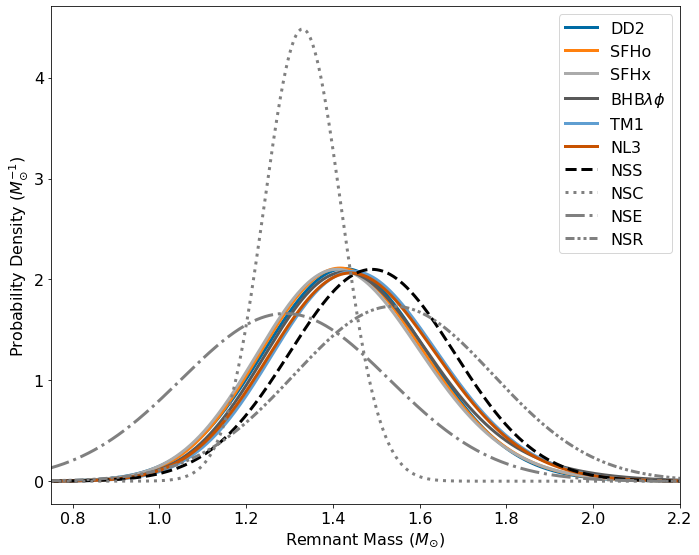

In [409]:
# Obs plots
plt.figure(figsize=(10, 8))

for i in range(len(qs)):
    plt.plot(grid, qs[i], lw=3, label=f"{state_names[i]}") #in color

plt.plot(grid, ps[0], lw=3, linestyle='--', c="black", label="NSS")
plt.plot(grid, ns_pdfs[0], lw=3, linestyle=':', c="gray", label="NSC")
plt.plot(grid, ns_pdfs[1], lw=3, linestyle='-.', c="gray", label="NSE")
plt.plot(grid, ns_pdfs[2], lw=3, linestyle=(0, (3, 1, 1, 1, 1, 1)), c="gray", label="NSR")


# plt.title(f"Observered Posterior with Bandwidth {band}")
plt.xlim(0.75, 2.2)
plt.xlabel(r"Remnant Mass ($M_{\odot}$)")
plt.ylabel(r"Probability Density ($M_{\odot}^{-1}$)")
plt.tight_layout(); plt.legend(loc='best')
plt.savefig(f'../vis/w_kde_{band}.png', dpi=500)

In [ ]:
# Obs plots
plt.figure(figsize=(10, 8))

for i in range(len(qs)):
    plt.plot(grid, qs[i], lw=3, label=f"State: {i}") #in color

plt.plot(grid, ps[0], lw=3, linestyle='--', label="Real PD") #black

plt.title(f"Observered Posterior with Bandwidth {band}")
plt.xlim(0, 3)
plt.xlabel(r"Remnant Mass ($M_{\odot}$)")
plt.ylabel(r"Probability Density ($M_{\odot}^{-1}$)")
plt.tight_layout(); plt.legend(loc='best')
plt.savefig(f'../vis/w_kde_{band}.png', dpi=350)

In [ ]:
plt.figure(figsize=(10,8))

for state in range(0, 6):
    data = states_data[state]
    target = data['remnant_mass_noisy'].to_numpy()
    x, y = FFTKDE(bw='silverman').fit(target).evaluate()
    plt.plot(x, y, label=f"State {state}: {state_names[state]}", lw=3)

plt.xlim(0, max(x))
plt.title('Unweighted KDEs')
plt.xlabel(r"Remnant Mass ($M_{\odot}$)")
plt.ylabel(r"Probability Density ($M_{\odot}^{-1}$)")
plt.tight_layout(); plt.legend(loc='best')
plt.savefig('uw_kde.png', dpi=350)

In [ ]:
plt.figure(figsize=(10,8))

for state in range(0, 6):
    data = states_data[state]
    ns_data = data[data['outcome'] == 0]
    target = ns_data['remnant_mass_noisy'].to_numpy()
    x, y = FFTKDE(bw='ISJ').fit(target, weights=ns_data['weights'].to_numpy()).evaluate()
    plt.plot(x, y, label=f"State {state}: {state_names[state]}", lw=3)
    
plt.xlim(0, max(x))
plt.title('Weights Neutron Star KDEs')
plt.xlabel(r"Remnant Mass ($M_{\odot}$)")
plt.ylabel(r"Probability Density ($M_{\odot}^{-1}$)")
plt.tight_layout(); plt.legend(loc='best')
plt.savefig('w_ns.png', dpi=350)

In [ ]:
plt.figure(figsize=(10,8))

for state in range(6):
    if state == 2:
        continue
    data = states_data[state]
    bh_data = data[data['outcome'] != 0]
    target = bh_data['remnant_mass_noisy'].to_numpy()
    kde_ = FFTKDE(bw='ISJ')
    kde_.fit(target, weights=bh_data['weights'].to_numpy())
    print(kde_.bw(target.reshape(-1, 1)))
    x, y = kde_.evaluate()
    #x, y = FFTKDE(bw='silverman').fit(target, weights=bh_data['weights'].to_numpy()).evaluate()
    plt.plot(x, y, label=f"State {state}: {state_names[state]}", lw=3)

plt.xlim(0, max(x))
plt.title('Weighted Blackhole KDEs')
plt.xlabel(r"Remnant Mass ($M_{\odot}$)")
plt.ylabel(r"Probability Density ($M_{\odot}^{-1}$)")
plt.tight_layout(); plt.legend(loc='best')
plt.savefig('w_bh.png', dpi=350)

In [ ]:
    pd.concat([raw_data.sample(frac=1, replace=True, ignore_index=True)] * 1000, ignore_index=True).duplicated().value_counts()

In [ ]:
temp = pd.read_csv("/Users/mikhailm.meskhi/Desktop/black_holes_5.csv")

In [ ]:
plt.plot([1], [0.52736905], marker='s')
plt.plot([1], [0.5291840383610322], marker='*')
plt.plot([1], [0.54274186], marker='s')

In [ ]:
temp

In [ ]:
plt.hist(pd.to_numeric(temp['KL'][0:499]), 30)